# Deep backward schemes for high-dimensional nonlinear PDEs

In [13]:
%pip install -e ..

Obtaining file:///Users/ryan/Developer/Projects/dbdp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dbdp (pyproject.toml) ... done
  Created wheel for dbdp: filename=dbdp-0.1-0.editable-py3-none-any.whl size=2581 sha256=0acd4b76fecb5caa70a061c2da95fbbe2b8882a80009ab98cf8c00bd03c00385
  Stored in directory: /private/var/folders/p4/mbr166wd3zq78yjs07dgt9bc0000gn/T/pip-ephem-wheel-cache-mlr5ek69/wheels/28/28/14/5bf41b8af05a6d32ee13f909b4f2ba39f60ef95ce12f2405f9
Successfully built dbdp
  Attempting uninstall: dbdp
    Found existing installation: dbdp 0.1
    Uninstalling dbdp-0.1:
      Successfully uninstalled dbdp-0.1
Note: you may need to restart the kernel to use updated packages.


In [14]:
from dbdp import *

import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch: {torch.__version__} | Numpy: {np.__version__}")

PyTorch: 2.6.0 | Numpy: 2.2.3


## Example 1 :

$$
    \mu=0.2,\ \sigma=1,\ T=2,\ x_0=1
$$

$$
    g(x)=\cos(x)
$$

$$
    f(t,x,y,z)=(\cos(x)(e^{\frac{T-t}{2}}+\sigma^2/2)+\mu\sin(x))e^{\frac{T-t}{2}}-\frac{1}{2}(\sin(x)\cos(x)e^{T-t})^2+\frac{1}{2}(yz)^2
$$

In [15]:
mu = 0.2
sigma = 1.0

drift = lambda t, x: mu
diffusion = lambda t, x: sigma

sde = SDE(drift, diffusion, 1)
euler = EulerScheme(sde)

maturity = 2.0
time_steps = 240
dt = maturity / time_steps

sample_count = 1_000

x0 = torch.Tensor([1.0])
dim = x0.dim()


def f(t, x, y, z):
    a = torch.cos(x) * (np.exp((maturity - t) / 2) + sigma ** 2 / 2) + mu * torch.sin(x)
    b = -((torch.sin(x) * torch.cos(x) * np.exp(maturity - t)) ** 2) + (y * z) ** 2
    return a * np.exp((maturity - t) / 2) + b / 2


def g(x):
    return torch.cos(x)


def true_u(t, x):
    return np.exp((maturity - t) / 2) * torch.cos(x)

In [16]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(12, 6), dpi=200)
    plt.title("Evolution of training and test error")
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.loglog()
    plt.grid(alpha=0.5, ls="dotted")
    plt.tight_layout()
    plt.legend()

In [17]:
dbdp1 = DBDP1(f, g, maturity, time_steps, dim)
# dbdp1.load("../models/example-01.pt")

In [18]:
# Generating datas
dw = np.sqrt(dt) * torch.randn((sample_count, time_steps, dim))
x_paths = euler.build_path(x0, dt, dw)

print(f"Shape dw {dw.shape}")
print(f"Shape  x {x_paths.shape}")

Shape dw torch.Size([1000, 240, 1])
Shape  x torch.Size([1000, 241, 1])


In [19]:
trains_losses, tests_losses = dbdp1.train(x_paths, dw, num_epochs=100, batch_size=64)
# dbdp1.save("../models/example-01.pt")

Training: 100%|██████████| 240/240 [05:38<00:00,  1.41s/it]


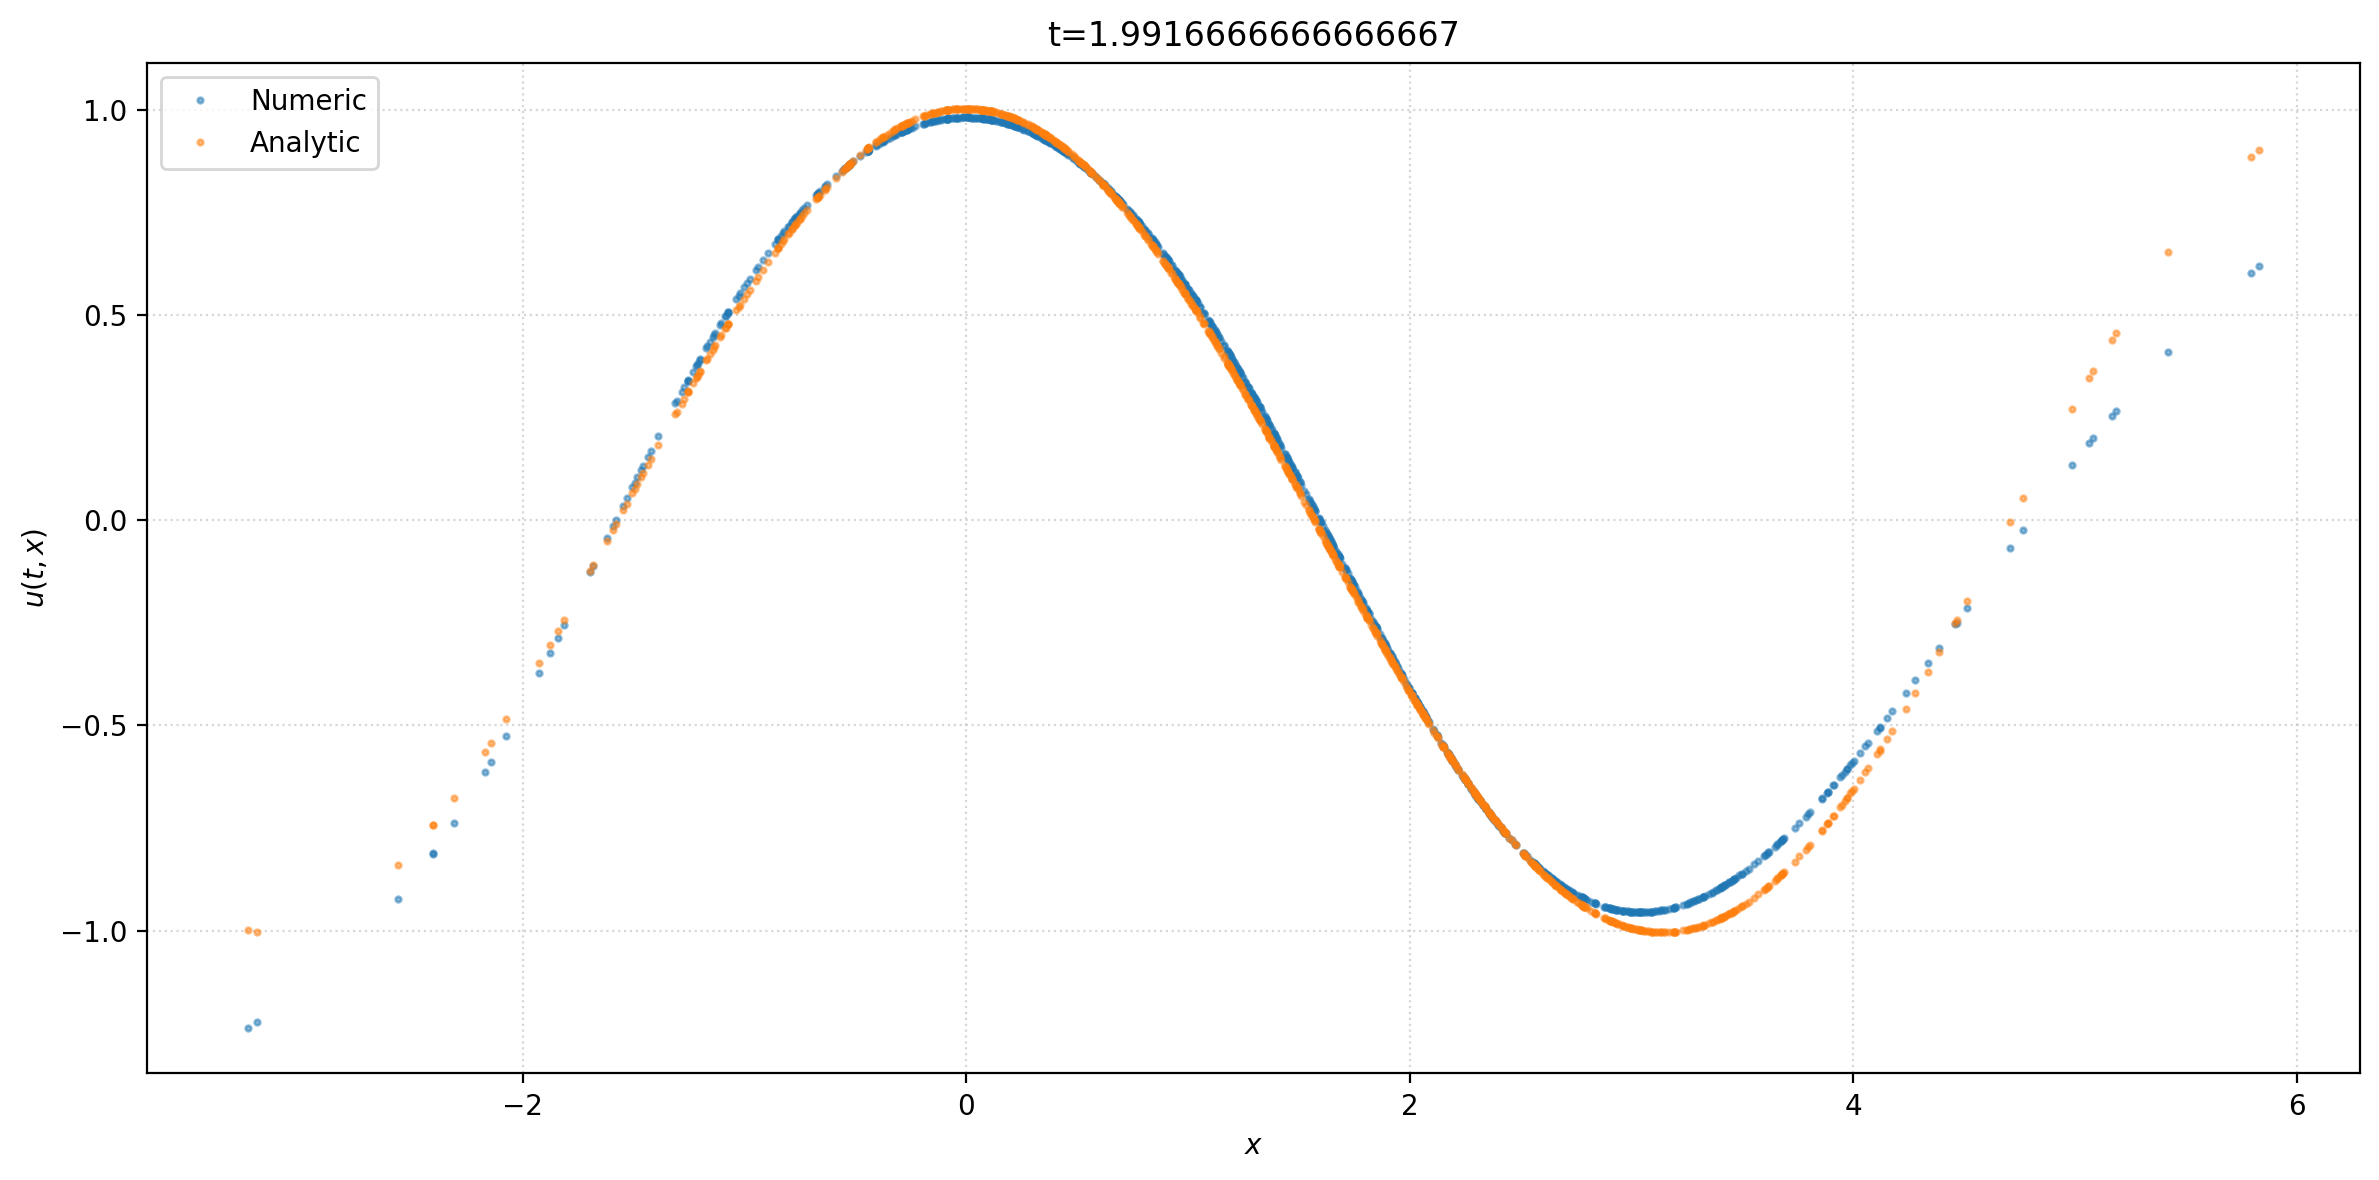

In [22]:
u_approx = dbdp1

time = np.linspace(0, maturity, time_steps + 1)
i = 240 - 1
t = time[i]
xs = x_paths[:, i].unsqueeze(1)[:, :, 0]
ys = u_approx(t, xs).detach()

plt.figure(figsize=(12, 6), dpi=200)
plt.title(f"t={t}")
plt.plot(xs, ys, ".", markersize=4, label="Numeric", alpha=0.5)
plt.plot(xs, true_u(t, xs), ".", markersize=4, label="Analytic", alpha=0.5)
plt.grid(alpha=0.5, ls="dotted")
plt.xlabel("$x$")
plt.ylabel("$u(t,x)$")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

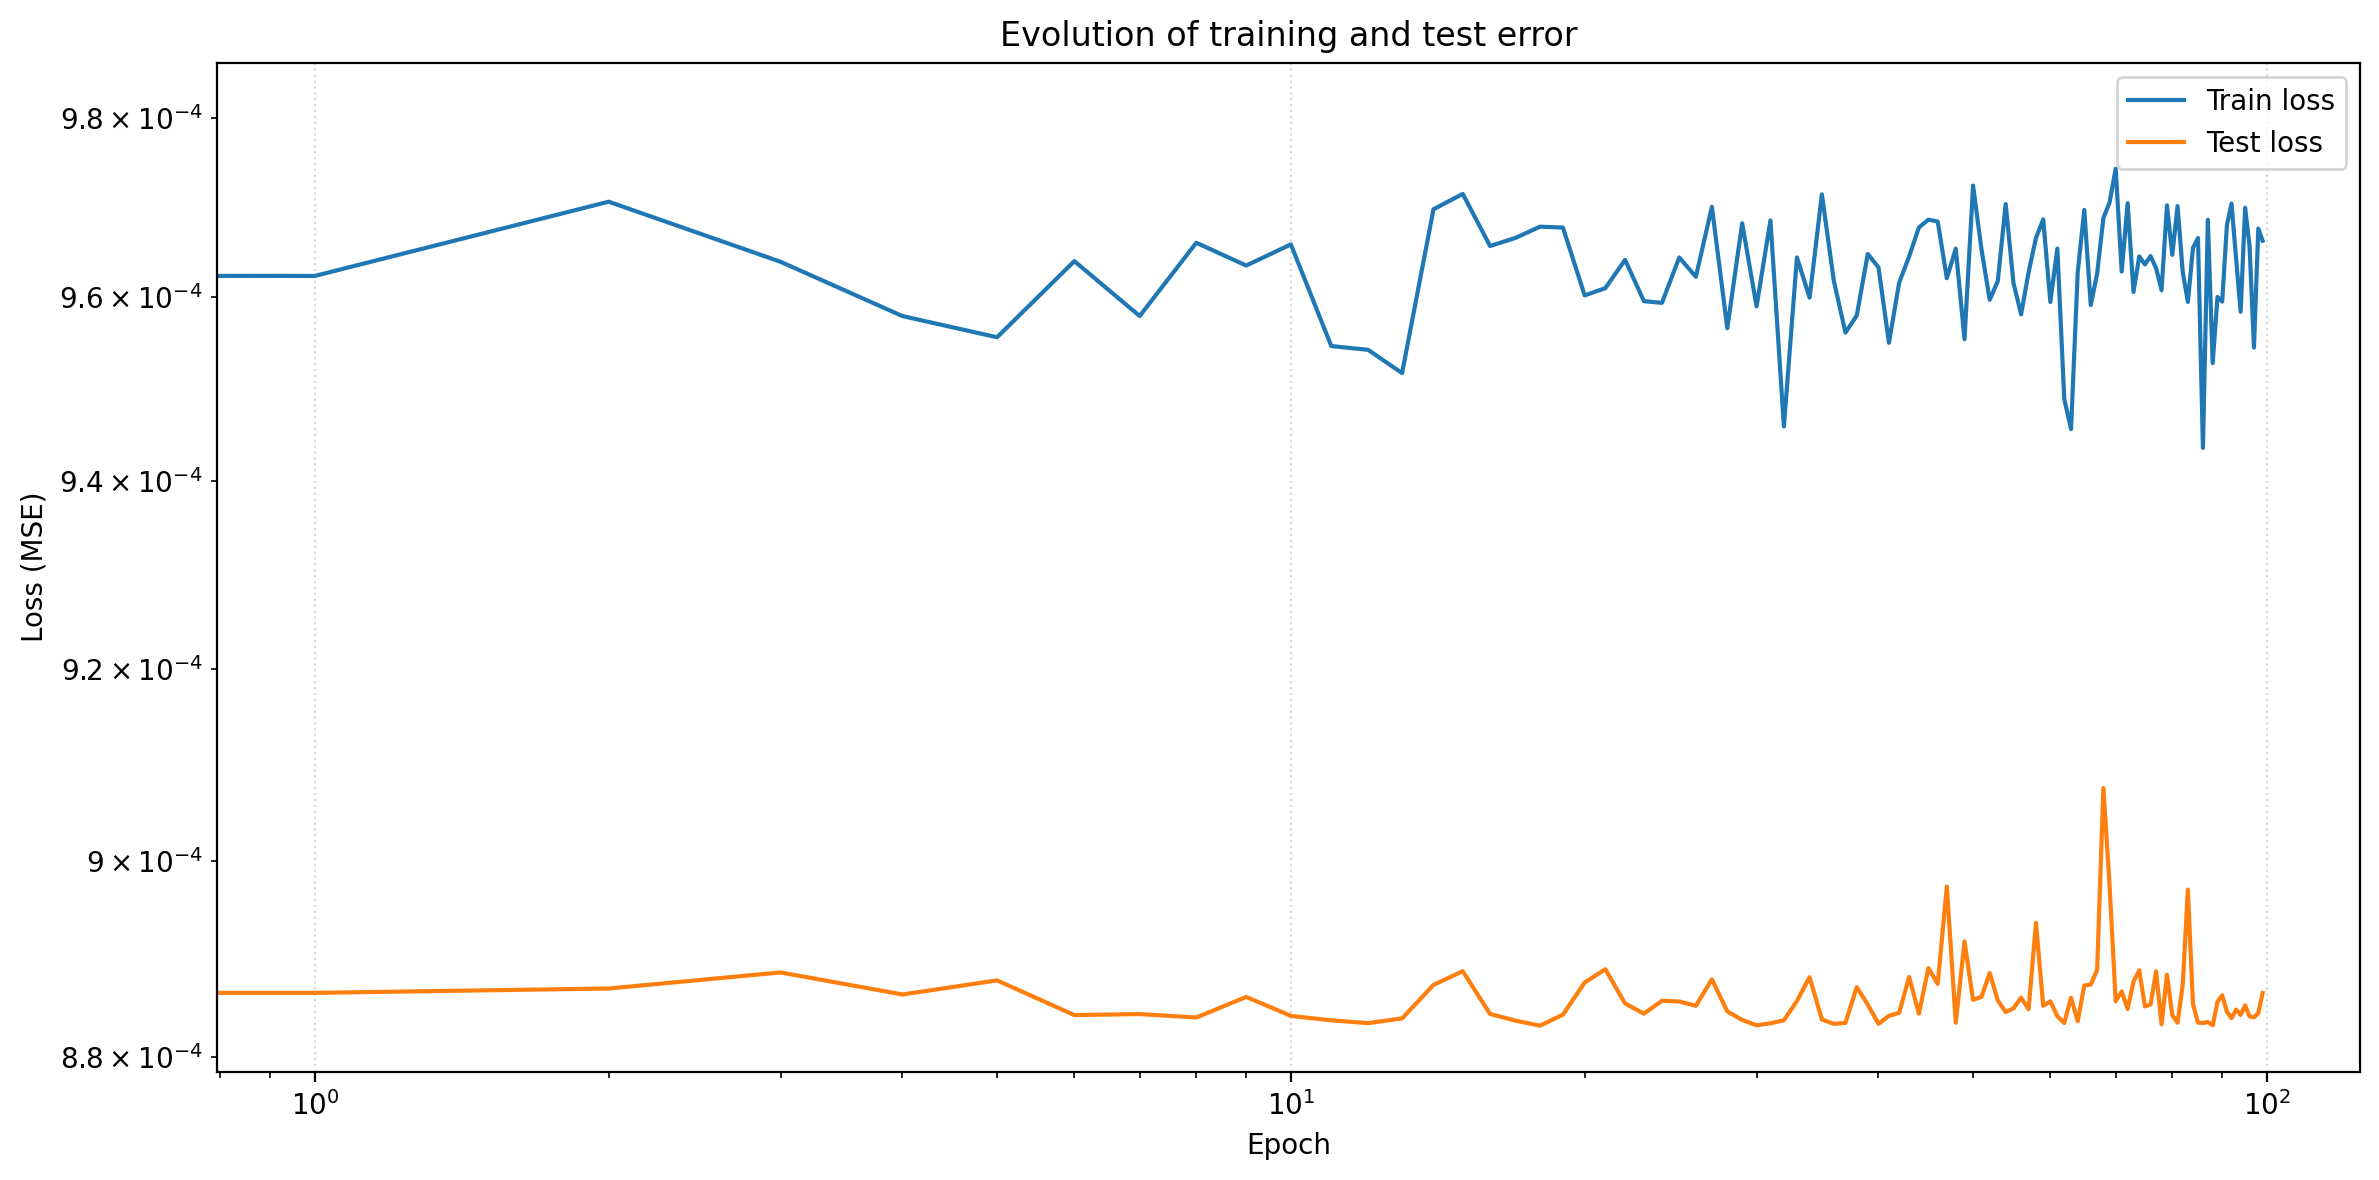

In [23]:
plot_losses(trains_losses[i], tests_losses[i])